# Auto-encoder for anomaly detection
In this notebook we pursue the idea of training a network to recognize "normal" (non - jumping) signals. This is done by using auto-encoder to reduce the dimensions of a signal to a given amount of dimensions and reconstructing it. Now the loss should be significantly higher for signals not in the training set.

In [3]:
import os, pickle

import numpy  as np
import pandas as pd

import matplotlib.pyplot as plt


import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score

# Colors using scheme
c = ["#" + i for i  in "264653-2a9d8f-e9c46a-f4a261-e76f51".split("-")]
from sklearn.metrics import roc_curve, roc_auc_score


def fft_abs_phase(input):
    transformed = np.fft.rfft(input)
    output      = np.concatenate([np.abs(transformed), np.cos(np.angle(transformed)), np.sin(np.angle(transformed))],
                                  axis = 1)
    return output
X_train, X_test, y_train, y_test = pd.read_pickle("../../common_data/train_test_data.dat")

In [23]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_train_bkg = X_train[y_train == 0, :]

## Define Auto-Encoder / Decoder

In [24]:
# Hyper parameters
input_dims   = 200
latent_dims  = 1
hidden_dims  = 32
# dense_layers = 1
dropout      = 0.10

In [25]:
# Tensorflow imports
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, LSTM , Bidirectional, Reshape, Flatten, Dropout, Conv1D
from tensorflow.keras.losses import MeanSquaredError


In [26]:
class AutoEncoderLSTM(Model):
    def __init__(self, latent_dims, hidden_dims, input_dims):
        super(AutoEncoderLSTM, self).__init__()
        self.latens_dims = latent_dims
        
        self.encoder = Sequential([
            # Dense(hidden_dims, activation = "relu"),
            Reshape((input_dims, 1)),
            Bidirectional(LSTM(hidden_dims, return_sequences=True, dropout = dropout)),
            Bidirectional(LSTM(hidden_dims, return_sequences=True, dropout = dropout)),
            Flatten(), 
            Dense(hidden_dims, activation = "tanh"),
            Dropout(dropout),
            Dense(hidden_dims),
            Dense(latent_dims)
        ])
        
        self.decoder = Sequential([
            Dense(input_dims, activation = "relu"),
            Dropout(dropout),
            Reshape((input_dims, 1)),
            Bidirectional(LSTM(hidden_dims, return_sequences=True, dropout = dropout)),
            Flatten(), 
            Dense(input_dims)
        ])
    
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded 


class AutoEncoderConv(Model):
    def __init__(self, latent_dims, hidden_dims, input_dims):
        super(AutoEncoderConv, self).__init__()
        self.latens_dims = latent_dims
        
        self.encoder = Sequential([
            Reshape((input_dims, 1)),
            Conv1D(hidden_dims, 4, padding = "same", strides = 2, activation = "tanh"),
            Dropout(dropout),
            Conv1D(latent_dims, 4, padding = "same", strides = 2, activation = "tanh"), 
            Flatten(),
            Dropout(dropout),
            Dense(latent_dims)
        ])
        
        self.decoder = Sequential([
            Reshape((latent_dims, 1)),
            Conv1D(latent_dims, 4, padding = "same", strides = 2, activation = "tanh"),
            Dropout(dropout),
            Conv1D(hidden_dims, 4, padding = "same", strides = 2, activation = "tanh"), 
            Flatten(),
            Dropout(dropout),
            Dense(input_dims)
        ])
    
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded 






In [27]:
autoencoder = AutoEncoderLSTM(latent_dims, hidden_dims, input_dims)

autoencoder.compile(optimizer = "adam",
                    loss = MeanSquaredError(reduction = "auto"))

autoencoder.build((None, input_dims))

In [28]:
autoencoder.summary()

Model: "auto_encoder_lstm_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 1)                 444257    
                                                                 
 sequential_3 (Sequential)   (None, 200)               2569304   
                                                                 
Total params: 3,013,561
Trainable params: 3,013,561
Non-trainable params: 0
_________________________________________________________________


In [29]:
from keras_lr_finder import LRFinder
# finder = LRFinder(autoencoder)

# finder.find(X_train, X_train, 1e-7, 1e-1, batch_size = 32)

# finder.plot_loss()

import tensorflow.keras.backend as K


In [30]:
K.set_value(autoencoder.optimizer.learning_rate, 1e-3)
K.set_value(autoencoder.optimizer.decay,         1e-5)

from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor = "val_loss", patience = 3, restore_best_weights = True)

autoencoder.fit(X_train_bkg, X_train_bkg, 
                batch_size = 32,
                epochs     = 50, 
                validation_split = 0.10,
                shuffle = True, 
                callbacks = [early_stop])

Epoch 1/50
 77/225 [=========>....................] - ETA: 49s - loss: 0.5603

KeyboardInterrupt: 

In [ ]:
enc = autoencoder.encoder(scaler.transform(X_test))
dec = autoencoder.decoder(enc)
dec = scaler.inverse_transform(dec)
enc = enc.numpy()



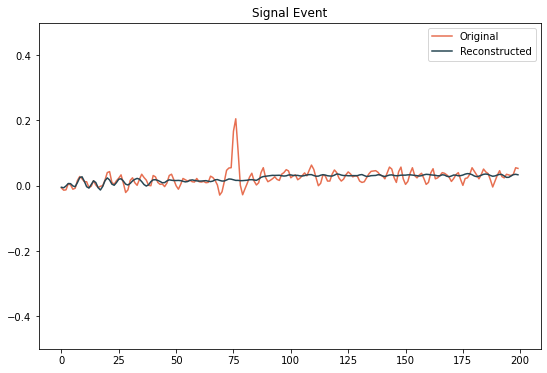

In [ ]:
plot_example = 748
fig, ax = plt.subplots(figsize = (9, 6))
ax.plot(X_test[plot_example, :], c = color_list[4], label = "Original") 
ax.plot(dec[plot_example, :],    c = color_list[0], label = "Reconstructed")

if y_test[plot_example] == 1:
    ax.set_title("Signal Event")
else:
    ax.set_title("Background Event")

ax.set_ylim(-0.5, 0.5)

ax.legend()

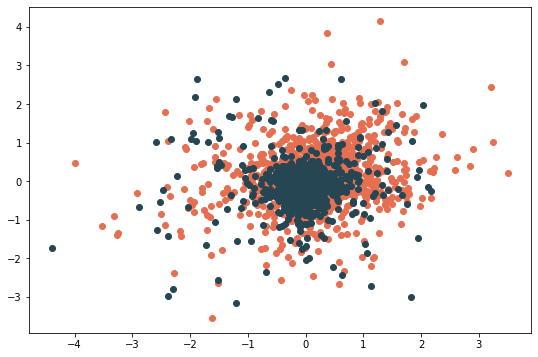

In [ ]:
fig, ax = plt.subplots(figsize = (9, 6))

mask = y_test == 1

ax.scatter(enc[mask, 0],  enc[mask, 1],  c = color_list[4], marker = "o", label = "Signal") 
ax.scatter(enc[~mask, 0], enc[~mask, 1], c = color_list[0], marker = "o", label = "background")

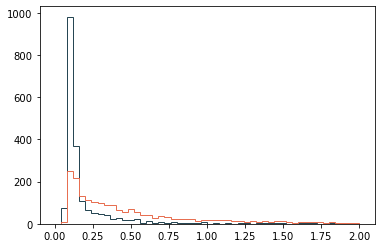

In [ ]:
x_test_bkg = scaler.transform(X_test[y_test == 0])
x_test_sig = scaler.transform(X_test[y_test == 1])

mae = MeanSquaredError(reduction = "none")

bkg_losses = mae(x_test_bkg, autoencoder(x_test_bkg)).numpy()
sig_losses = mae(x_test_sig, autoencoder(x_test_sig)).numpy()

plt.hist(bkg_losses, bins = 50, histtype = "step", color = color_list[0], range = (0, 2), label = "background")
plt.hist(sig_losses, bins = 50, histtype = "step", color = color_list[4], range = (0, 2), label = "signal");



In [ ]:
losses = mae(X_test, autoencoder(scaler.transform(X_test))).numpy()
np.argmax(losses)

206

AUC: 0.63


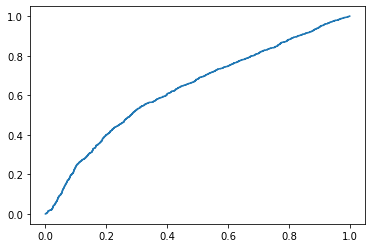

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

x, y, _ = roc_curve(y_test, losses)
auc     = roc_auc_score(y_test, losses)

plt.plot(x, y)
print(f"AUC: {auc:.2f}")